In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
%matplotlib inline
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None



In [39]:
NUM_MELHORES = 65
MIN_ALUNOS = 30 #Mínimo de alunos que fizeram Enem para considerar a escola

In [40]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837
CO_ELEVA = 33178860
CO_ST_INACIO = 33063729
CO_MUN_RIO = 3304557
CO_UF_RIO = 33

In [41]:

df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')



In [42]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')


 ## Cálculo da nota final
 Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

 O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas.

 Algumas universidades consideram um peso distinto de acordo com a disciplina

 ### Pesos UFRJ

 Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

 - Redação: peso 3 (mínimo 300)
 - Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
     - Matemática tem peso 4
 - Ciências Econômicas, Geologia e Meteorologia
     - Matemática peso 3
 - Engenharias e Química Industrial
     - Ciências da Natureza: peso 4
 - Geologia
     - Ciências da Natureza: peso 3
 - Humanas
     - Ciências Humanas e Linguagens: peso 2



In [43]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4) #peso do Inep com redação igual os demais

In [44]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

#df_enem_rio me dá as notas do enem de cada aluno de escola do rio de janeiro 
df_enem_rio['nota_final'] = df_enem_rio.loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]\
                                       .apply(media_ponderada, axis=1)\
                                       .round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,529.6,683.3,652.5,740.3,960.0,806.0
3,483.7,602.4,558.1,453.7,600.0,562.0
4,431.7,560.9,479.7,557.0,560.0,534.0


In [45]:
#df_enem sãos as notas agrupadas por escola e ordenadas da melhor para a pior

notas_agg = {col: (col, 'median') for col in notas_cols}
notas_agg['mediana'] = ('nota_final', 'median')
notas_agg['num'] = ('nota_final', 'count')

df_enem = df_enem_rio.groupby('CO_ESCOLA')\
                         .agg(**notas_agg)\
                         .sort_values('mediana', ascending=False)\
                         .query('num > @MIN_ALUNOS')#corte arbitrário
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33057206,646.50,693.00,649.40,768.60,940.0,807.0,83
33135371,662.70,691.40,635.00,763.20,920.0,803.0,91
33062633,689.50,702.85,645.70,801.10,900.0,800.5,62
33165920,645.90,697.60,638.30,768.70,920.0,798.0,51
33055866,668.40,678.50,630.50,755.60,920.0,798.0,31
...,...,...,...,...,...,...,...
33046565,445.05,509.00,469.60,488.55,360.0,430.0,46
33037515,461.30,543.45,504.90,476.00,390.0,429.0,31
33158746,451.05,532.80,481.95,467.35,360.0,427.0,83


In [46]:
df_enem['rank'] = df_enem.mediana.rank(ascending=False, method='min')

In [47]:
#vamos colocar o nome das escolas
df_enem = df_enem.merge(df_escolas[['NO_ENTIDADE', 'CO_ENTIDADE']], left_index=True, right_on='CO_ENTIDADE')

In [48]:
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE
177824,646.50,693.00,649.40,768.60,940.0,807.0,83,1.0,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,33057206
189289,662.70,691.40,635.00,763.20,920.0,803.0,91,2.0,COLEGIO CRUZEIRO - JACAREPAGUA,33135371
177267,689.50,702.85,645.70,801.10,900.0,800.5,62,3.0,COL DE SAO BENTO,33062633
193270,645.90,697.60,638.30,768.70,920.0,798.0,51,4.0,COLEGIO E CURSO PENSI,33165920
176775,668.40,678.50,630.50,755.60,920.0,798.0,31,4.0,COL MARILIA MATTOSO,33055866
...,...,...,...,...,...,...,...,...,...,...
177195,445.05,509.00,469.60,488.55,360.0,430.0,46,795.0,CIEP 375 WILSON GREY,33046565
174380,461.30,543.45,504.90,476.00,390.0,429.0,31,797.0,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,33037515
195642,451.05,532.80,481.95,467.35,360.0,427.0,83,798.0,UNIDADE ESCOLAR DA FUNDACAO ROBERTO MARINHO,33158746
189874,456.80,533.20,486.65,494.50,360.0,427.0,39,798.0,CIEP 331 LYSIA BERNARDES,33093709


Respondendo uma pergunta sinistra: quantas escolas com ensino médio não tiveram qualquer aluno fazendo Enem?

ih, não dá, já filtrei o df_enem

In [49]:
my_order = df_enem.head(NUM_MELHORES).NO_ENTIDADE

 Ajustar no gráfico abaixo:

 - diminuir nomes de escola muito grandes


In [50]:
df_nomes_grandes = df_enem[:100][['CO_ENTIDADE', 'NO_ENTIDADE']]
df_nomes_grandes['comprido'] = df_nomes_grandes.NO_ENTIDADE.str.len()
df_nomes_grandes.sort_values('comprido', ascending=False).head(30)

#vamos ajustar alguns nomes
df_enem.loc[df_enem.CO_ENTIDADE==33176825, 'NO_ENTIDADE'] = 'COLEGIO SANTO AGOSTINHO - BARRA'
df_enem.loc[df_enem.CO_ENTIDADE==33066523, 'NO_ENTIDADE'] = 'CAP - UERJ'
df_enem.loc[df_enem.CO_ENTIDADE==33132534, 'NO_ENTIDADE'] = 'GARRA VESTIBULARES - UNID 1'
df_enem.loc[df_enem.CO_ENTIDADE==33057206, 'NO_ENTIDADE'] = 'INSTITUTO GAYLUSSAC'
df_enem.loc[df_enem.CO_ENTIDADE==33142726, 'NO_ENTIDADE'] = 'COL ISRAELITA LIESSIN'
df_enem.loc[df_enem.CO_ENTIDADE==33027722, 'NO_ENTIDADE'] = 'COLEGIO SAGRADO CORACAO DE JESUS'
df_enem.loc[df_enem.CO_ENTIDADE==33065250, 'NO_ENTIDADE'] = 'CAP - UFRJ'
df_enem.loc[df_enem.CO_ENTIDADE==33106754, 'NO_ENTIDADE'] = 'COLEGIO PROF CLOVIS TAVARES PRO-UNI'
df_enem.loc[df_enem.CO_ENTIDADE==33155259, 'NO_ENTIDADE'] = 'COLEGIO SALESIANO REGIAO OCEANICA'

for i, j in (('COLEGIO', 'COL'),
             ('INSTITUTO', 'INST'),
             ('FILIAL', '-'),
             ('UNIDADE ', ''),
             ('PROFESSOR', 'PROF'),
             ('EDUCACIONAL', 'EDUC.'),
            ):
    df_enem['NO_ENTIDADE'] = df_enem.NO_ENTIDADE.str.replace(i, j)

df_nomes_grandes.sort_values('comprido', ascending=False).head(30)    

,CO_ENTIDADE,NO_ENTIDADE,comprido
194893,33176825,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,68
176505,33066523,INSTITUTO DE APLICACAO FERNANDO RODRIGUES DA S...,62
190241,33132534,GARRA VESTIBULARES ASS EDUCACIONAL LTDA - UNID 1,48
177824,33057206,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,45
190825,33142726,COL ISRAELITA BRAS A LIESSIN SCHOLEM ALEICHEM,45
174865,33027722,COLEGIO FRANCISCANO SAGRADO CORACAO DE JESUS,44
175255,33065250,COL DE APLIC DA UNIV FED DO RIO DE JANEIRO,42
196245,33155259,ISJB - COLEGIO SALESIANO REGIAO OCEANICA,40
187709,33106754,COLEGIO PROFESSOR CLOVIS TAVARES PRO-UNI,40
190475,33104247,INSTITUTO NOSSA SENHORA DA PIEDADE II,37


In [51]:
df_enem['rotulo'] = df_enem.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)



In [52]:
df_enem


,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE,rotulo
177824,646.50,693.00,649.40,768.60,940.0,807.0,83,1.0,INST GAYLUSSAC,33057206,Inst Gaylussac 083/ 1
189289,662.70,691.40,635.00,763.20,920.0,803.0,91,2.0,COL CRUZEIRO - JACAREPAGUA,33135371,Col Cruzeiro - Jacarepagua 091/ 2
177267,689.50,702.85,645.70,801.10,900.0,800.5,62,3.0,COL DE SAO BENTO,33062633,Col De Sao Bento 062/ 3
193270,645.90,697.60,638.30,768.70,920.0,798.0,51,4.0,COL E CURSO PENSI,33165920,Col E Curso Pensi 051/ 4
176775,668.40,678.50,630.50,755.60,920.0,798.0,31,4.0,COL MARILIA MATTOSO,33055866,Col Marilia Mattoso 031/ 4
...,...,...,...,...,...,...,...,...,...,...,...
177195,445.05,509.00,469.60,488.55,360.0,430.0,46,795.0,CIEP 375 WILSON GREY,33046565,Ciep 375 Wilson Grey 046/795
174380,461.30,543.45,504.90,476.00,390.0,429.0,31,797.0,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,33037515,Ciep 999 Dom Pedro Dalcantara De Braganca Prim...
195642,451.05,532.80,481.95,467.35,360.0,427.0,83,798.0,ESCOLAR DA FUNDACAO ROBERTO MARINHO,33158746,Escolar Da Fundacao Roberto Marinho 083/798
189874,456.80,533.20,486.65,494.50,360.0,427.0,39,798.0,CIEP 331 LYSIA BERNARDES,33093709,Ciep 331 Lysia Bernardes 039/798


## Distribuição das notas parece bimodal

Um monte de escolas com notas baixa (500), depois outro grupo com notas mais altas (700). Seria legal ver as distribuições por grupos.

In [53]:
ax = df_enem.mediana.hist(bins=24).plot();
#ax.tick_params(which='both', bottom=False, labelbottom=False)

<IPython.core.display.Javascript object>

## Comparando distribuições das escolas

Legenda: Nome da escola <nº alunos fizeram Enem>/<posição ranking nota final>

In [54]:


def compara_distribuicoes(nota):
    sns.set(rc={'figure.figsize':(14,18), 'axes.xmargin': .1})
    #sns.palplot(sns.hls_palette(8, l=.3, s=.8))
    
    nota_agrupada = nota
    if nota=='nota_final':
        nota_agrupada = 'mediana'
    
    df_top = df_enem.sort_values(nota_agrupada, ascending=False).head(NUM_MELHORES)
    ax = sns.boxplot(data=df_enem_rio, y='CO_ESCOLA', x=nota, orient='h'
                     ,order=df_top.CO_ENTIDADE)
    ax.set(ylabel='', xlabel='')
    plt.gcf().subplots_adjust(top=.95)
    plt.suptitle(f'{nota} por escola',x=0, size=24, );
    locs, _ = plt.yticks()
    plt.yticks(locs, df_top.rotulo);
    ax.set_xlim(300, 1000)
    

compara_distribuicoes('nota_final');




Um dado estranho, o Santo Inácio tem 245 alunos que disseram que completaram agora, mas há apenas 235 no 3º ano de 2018. Será que é preenchimento errado? Será que estou contando jovens e adultos? Será que acontece o mesmo com outras escolas?

In [55]:
compara_distribuicoes('NU_NOTA_MT');

In [56]:
compara_distribuicoes('NU_NOTA_REDACAO');



In [57]:
compara_distribuicoes('NU_NOTA_CH');


 ## Sobrevivência no ensino médio

 Quantos dos alunos que começam o ensino médio fazem Enem?

 Motivos para diminuir:
 - Maus alunos são expulsos
 - Maus alunos não acreditam que passarão no Enem
 - Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

 Motivos para aumentar:
 - Crise econômica (escolas públicas)
 - Bolsa para bons alunos

 ### ideias
 - comparar com último ano (dá ideia melhor da seleção feita pela escola)
 - comparar com quem fez prova (ideia melhor de auto seleção)

In [58]:
etapa_col = 'TP_ETAPA_ENSINO'
primeiro_ano = [25,  30, 35]
# todo: tratar ensinos médios de 4 anos
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')




In [59]:
df_ano_um = df_primeiro_ano_turmas.groupby(['id_escola', 'ano'])['num_matriculas'].sum()
CO_ELEVA=33178860
df_ano_um = df_ano_um.unstack()
df_ano_um



ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
id_escola,,,,,,,,,,,,
33000026,90.0,73.0,51.0,36.0,55.0,63.0,54.0,51.0,56.0,41.0,39.0,35.0
33000042,216.0,194.0,177.0,111.0,128.0,138.0,104.0,99.0,98.0,121.0,86.0,58.0
33000069,26.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33000077,108.0,102.0,149.0,194.0,207.0,210.0,228.0,230.0,262.0,291.0,280.0,274.0
33000115,NaN,NaN,NaN,23.0,6.0,15.0,7.0,12.0,9.0,21.0,22.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33551219,NaN,NaN,NaN,41.0,48.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN
33552223,NaN,NaN,NaN,NaN,11.0,NaN,4.0,7.0,5.0,NaN,4.0,2.0
33552231,NaN,NaN,NaN,13.0,15.0,20.0,29.0,20.0,33.0,18.0,20.0,19.0


<IPython.core.display.Javascript object>


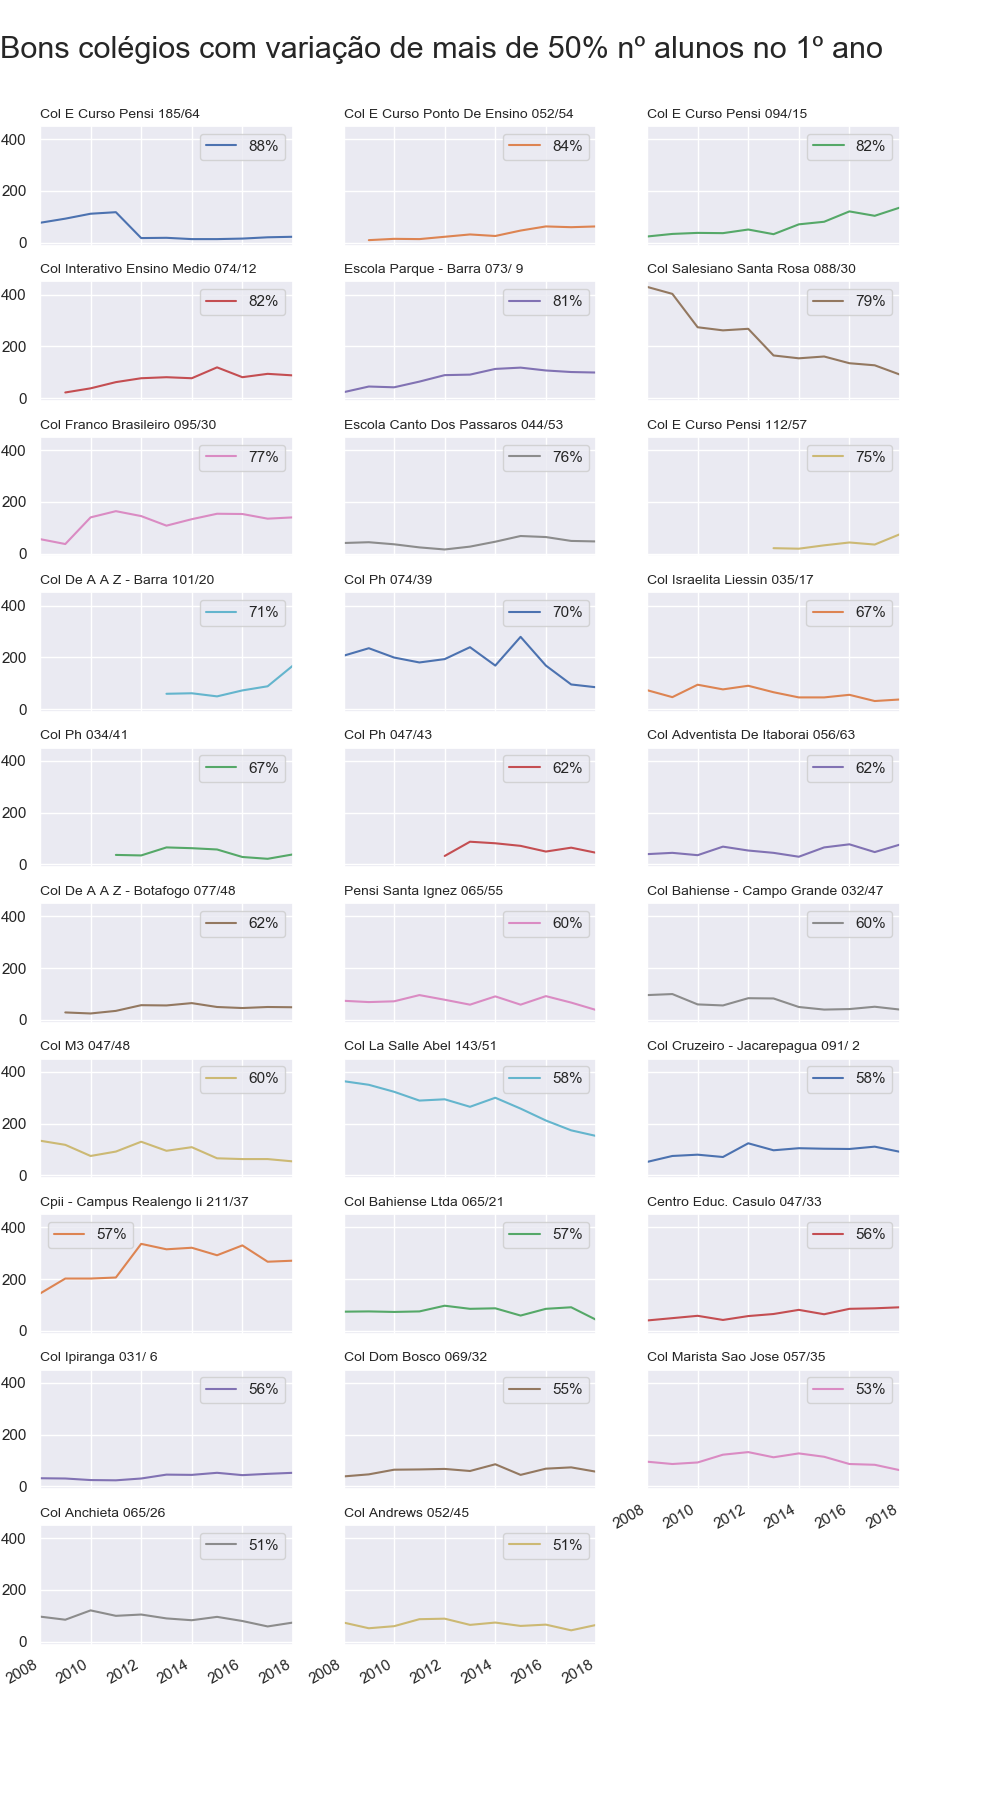

In [66]:
df_ano_um[df_ano_um==1] = np.nan  # tem um Pensi aqui com dado esquisito
porcentagem_variacao = .5
anos_idx = slice(0, 11) #colunas com dados de alunos no primeiro ano
df = (df_ano_um.drop(2007, axis='columns')
          .merge(df_enem.head(NUM_MELHORES)[['CO_ENTIDADE', 'rotulo', 'rank']], 
                 left_index=True, right_on='CO_ENTIDADE') #pegando nome das escolas e só das melhores
         .set_index('rotulo')
         .assign(alta_variacao=  #variação do número de alunos
                 lambda df: (df.iloc[:,anos_idx].max(axis='columns') - df.iloc[:,anos_idx].min(axis='columns'))
                            /df.iloc[:,anos_idx].max(axis='columns'))
         .query('alta_variacao > @porcentagem_variacao')
         .sort_values('alta_variacao', ascending=False) #mostrando primeiro as com maior variação
         .drop(['CO_ENTIDADE', 'rank'], axis='columns')
         .dropna(thresh=6) # joga fora quem não tem pelo menos 6 anos preenchidos
     )
alta_variacao = df.pop('alta_variacao')
df = df.T

sns.set(rc={'figure.figsize':(10,18), 'axes.xmargin': .1})
axes = df.plot.line(subplots=True, layout=(11,3), sharey=True);

i = 0
for axes2 in axes:
    for ax in axes2:
        if i < len(alta_variacao): 
            ax.set_title(df.columns[i], ha='left', x=0, size=10)
            #ax.legend().set_visible(False)
            ax.legend(['{:.0%}'.format(alta_variacao.iloc[i])])
        i += 1
sns.set()
fig = plt.gcf()
fig.suptitle("Bons colégios com variação de mais de {:.0%} nº alunos no 1º ano".format(porcentagem_variacao), 
                 size=22, ha='left', x=0);
plt.subplots_adjust(hspace=.3, wspace=.2, left=.04, top=.93, bottom=0)
plt.xticks(range(2008, 2019));

In [ ]:
%debug

- Pedro II de Realengo aumentou bastante
- Abel reduzindo drasticamente
- 2012 queda drástica no Pensi, com outra filial aumentando
- PH varia muito (com queda drástica no final)

<IPython.core.display.Javascript object>


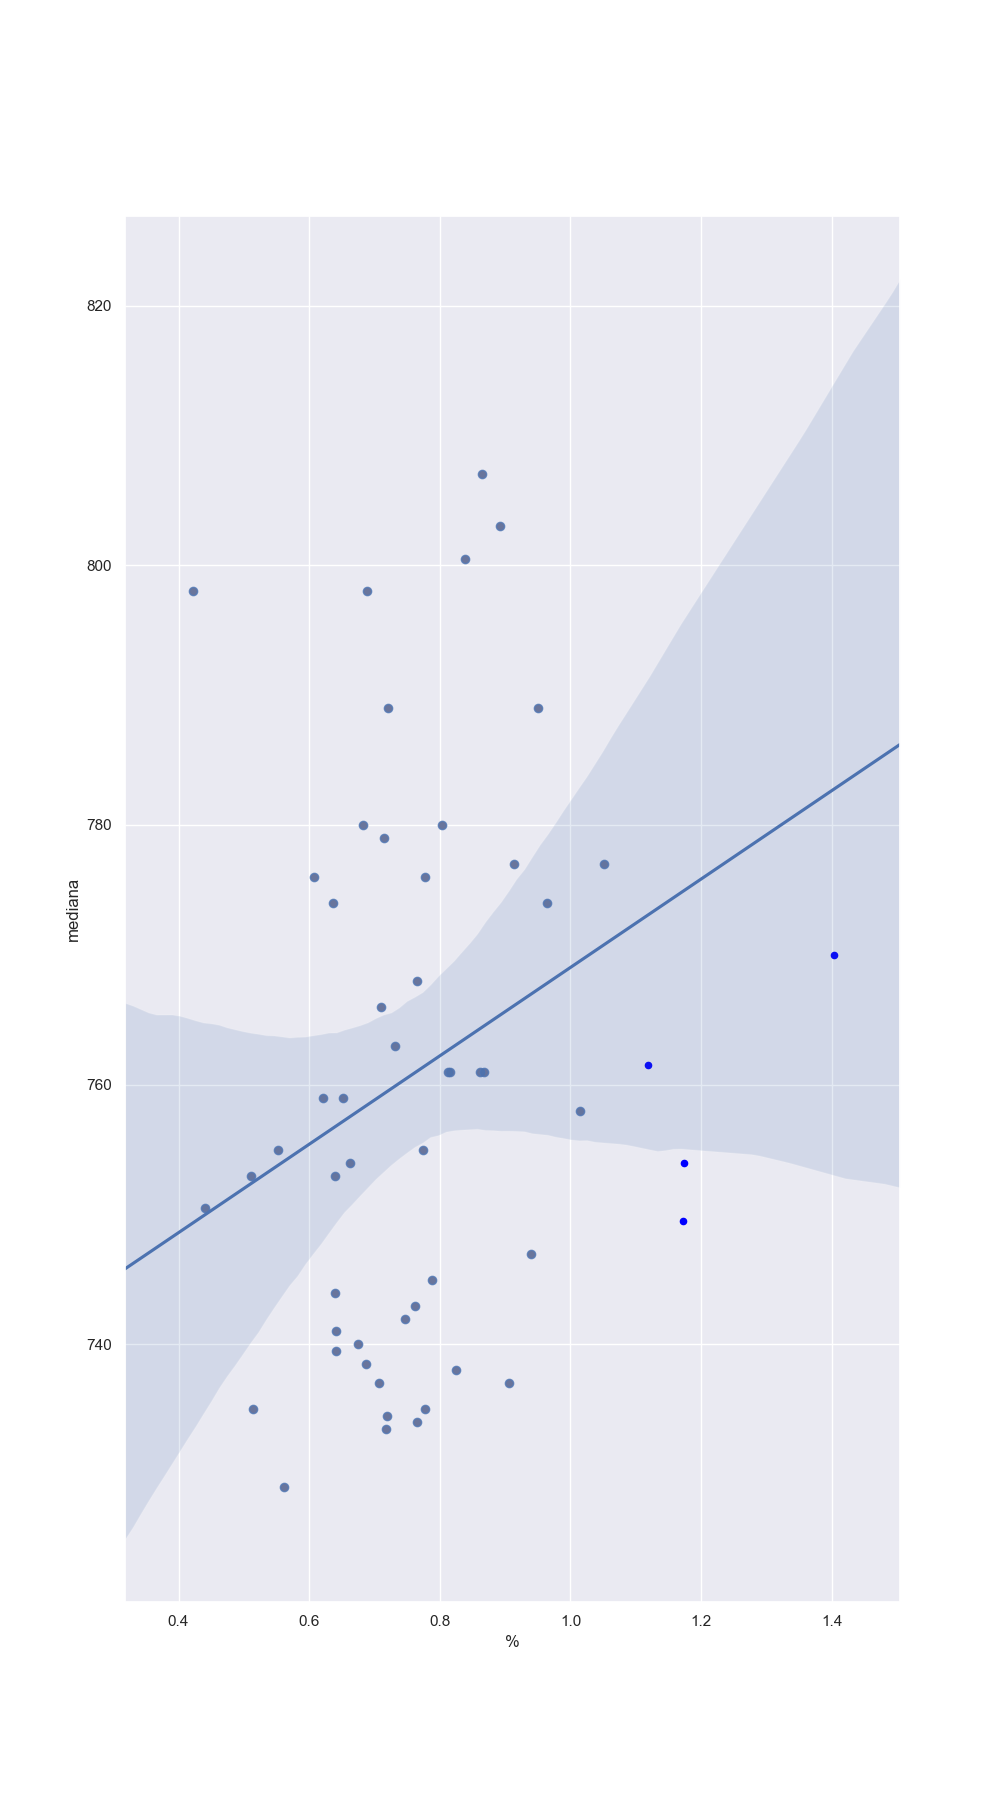

In [67]:
df = df_enem.head(NUM_MELHORES).set_index('CO_ENTIDADE')
df = df.join(df_ano_um[[2016]] )
df['%'] = df.num/df[2016]
df.sort_values('%', ascending=False)
df[df['%']<1.5].plot.scatter(x='%', y='mediana', c='blue');




Entre os bem colocados, quem aumenta o número de alunos?

In [68]:
df.loc[df['%']>=1, ['rotulo', '%', 'mediana', 'rank', 'num']].sort_values('%', ascending=False)

,rotulo,%,mediana,rank,num
CO_ENTIDADE,,,,,
33150931,Col E Curso Pensi 185/64,11.562500,729.0,64.0,185
33166820,Col E Curso Pensi 112/57,2.604651,736.5,57.0,112
33173990,Col De A A Z - Tijuca 063/12,1.968750,777.0,12.0,63
33228604,Col De A A Z - Botafogo 077/48,1.673913,742.0,48.0,77
33447225,Col De A A Z - Barra 101/20,1.402778,770.0,20.0,101
33110328,Col Ph 169/35,1.173611,754.0,35.0,169
33157901,Col Ph 034/41,1.172414,749.5,41.0,34
33105405,Col Ph 160/25,1.118881,761.5,25.0,160
33153450,Col Ph 186/12,1.050847,777.0,12.0,186


Quem aumenta o número de alunos? Pensi, de A a Z e PH. Estes são mais cursinhos pré-vestibular do que escolas. Vou tirá-los da lista. O Colégio [Dom Bosco](https://www.colegiodombosco.com.br/) é um colégio tradicional de Resende, então vou manter.

A correlação de 0.22 entre notas e perdas de alunos é fraca


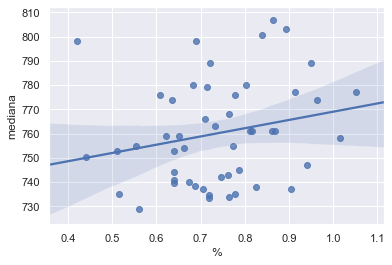

In [83]:
df_sem_outliers = df[df['%']<1.06]
sns.set()
sns.regplot(data=df_sem_outliers, x='%', y='mediana');
print("A correlação de {:.2n} entre notas e perdas de alunos é fraca".format(df_sem_outliers[['%', 'mediana']].corr().iat[0,1]))

In [94]:
df.loc[:, ['rotulo', 2016, 'num', '%', 'mediana', 'rank']].style.hide_index().format({'%': '{:.0%}'.format})

rotulo,2016,num,%,mediana,rank
Inst Gaylussac 083/ 1,96,83,86%,807,1
Col Cruzeiro - Jacarepagua 091/ 2,102,91,89%,803,2
Col De Sao Bento 062/ 3,74,62,84%,800.5,3
Col E Curso Pensi 051/ 4,121,51,42%,798,4
Col Marilia Mattoso 031/ 4,45,31,69%,798,4
Col Santo Inacio 245/ 6,258,245,95%,789,6
Col Ipiranga 031/ 6,43,31,72%,789,6
Col Santo Agostinho - Barra 185/ 8,nan,185,nan%,788,8
Escola Parque - Barra 073/ 9,107,73,68%,780,9
Col Santo Agostinho 135/ 9,168,135,80%,780,9


Entre os que mais diminuem o número de alunos também estão o Pensi e o PH. Impressionante, o CAP da Uerj tem bem poucos alunos fazendo Enem.

In [98]:
df_cursos = df_enem.loc[(df_enem.rotulo.str.contains('Ph|Curso Pensi|A A Z')),['rotulo', 'rank', 'mediana', 'CO_ENTIDADE']].style.hide_index()
df_cursos

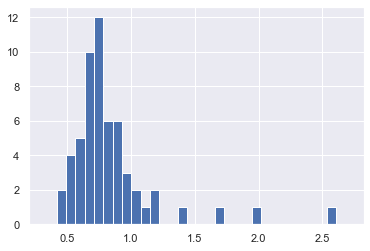

In [104]:
df.loc[df['%']<4, '%'].hist(bins=30).plot();

In [105]:
df.loc[df['%']<4, '%'].describe()

count    57.000000
mean      0.843562
std       0.357392
min       0.421488
25%       0.662791
50%       0.764706
75%       0.892157
max       2.604651
Name: %, dtype: float64

In [108]:
df['%'].quantile([i/10 for i in range(11)])

0.0     0.421488
0.1     0.593367
0.2     0.640686
0.3     0.687639
0.4     0.718871
0.5     0.764706
0.6     0.805357
0.7     0.864201
0.8     0.945767
0.9     1.172773
1.0    11.562500
Name: %, dtype: float64

Retirando quem eu não quero contar:
- todos os cursinhos: Pensi, A a Z e PH
- quem aumenta o número de alunos (só fica o Dom Bosco com variação 1.02)
- quem corta aluno demais, isto é os 80% que menos cortam

e entre estes pegaremos só os alunos que estão no 80 quantil. Isso privilegia as escolas que menos cortam alunos.

In [110]:
menor_quantil = df['%'].quantile(.2) #arbitrário
menor_quantil

0.6406856796116505

In [116]:
df_escolas_selecionadas = df[(df['%'] >= menor_quantil) & (df['%'] < 1.02)]
print("Antes dos cortes tínhamos {:n} melhores escolas, depois ficamos com {:n}, cortando {:.1%}"
      .format( NUM_MELHORES, len(df_escolas_selecionadas), (NUM_MELHORES-len(df_escolas_selecionadas))/NUM_MELHORES) )

Antes dos cortes tínhamos 65 melhores escolas, depois ficamos com 37, cortando 43.1%


Agora vem o radical, pegaremos apenas os melhores 80 percentil das notas.

In [117]:
#dever de casa

analisar colégios que estão com NAN na percentagem acima, especialmente o **Santo Agostinho Barra**